In [14]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import tensorflow as tf
from object_detection.utils import ops as utils_ops
from utils import label_map_util
from utils import visualization_utils as vis_util
%matplotlib inline

In [15]:
model_file_name = 'frozen_inference_graph.pb'
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(model_file_name, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [16]:
label_map_file_name = 'models/research/object_detection/data/mscoco_label_map.pbtxt' 
label_map = label_map_util.load_labelmap(label_map_file_name)
categories = label_map_util.convert_label_map_to_categories(label_map, 
                                                            max_num_classes=90, 
                                                            use_display_name=True)
category_index = label_map_util.create_category_index(categories)

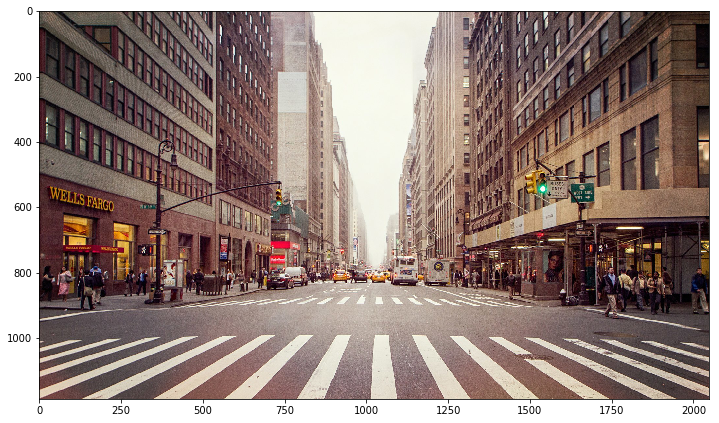

In [23]:
image_file_name = '354276-admin.jpg'
image = Image.open(image_file_name)
(im_width, im_height) = image.size
image_np = np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)
plt.figure(figsize=(12, 8))
plt.imshow(image_np)

In [24]:
with detection_graph.as_default():
    # Все операции в TensorFlow выполняются в сессии
    with tf.Session() as sess:
      # Готовим операции и входные данные
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image_np.shape[0], image_np.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Запуск поиска объектов на изображении
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image_np, 0)})

      # Преобразуем выходные тензоры типа float32 в нужный формат
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]

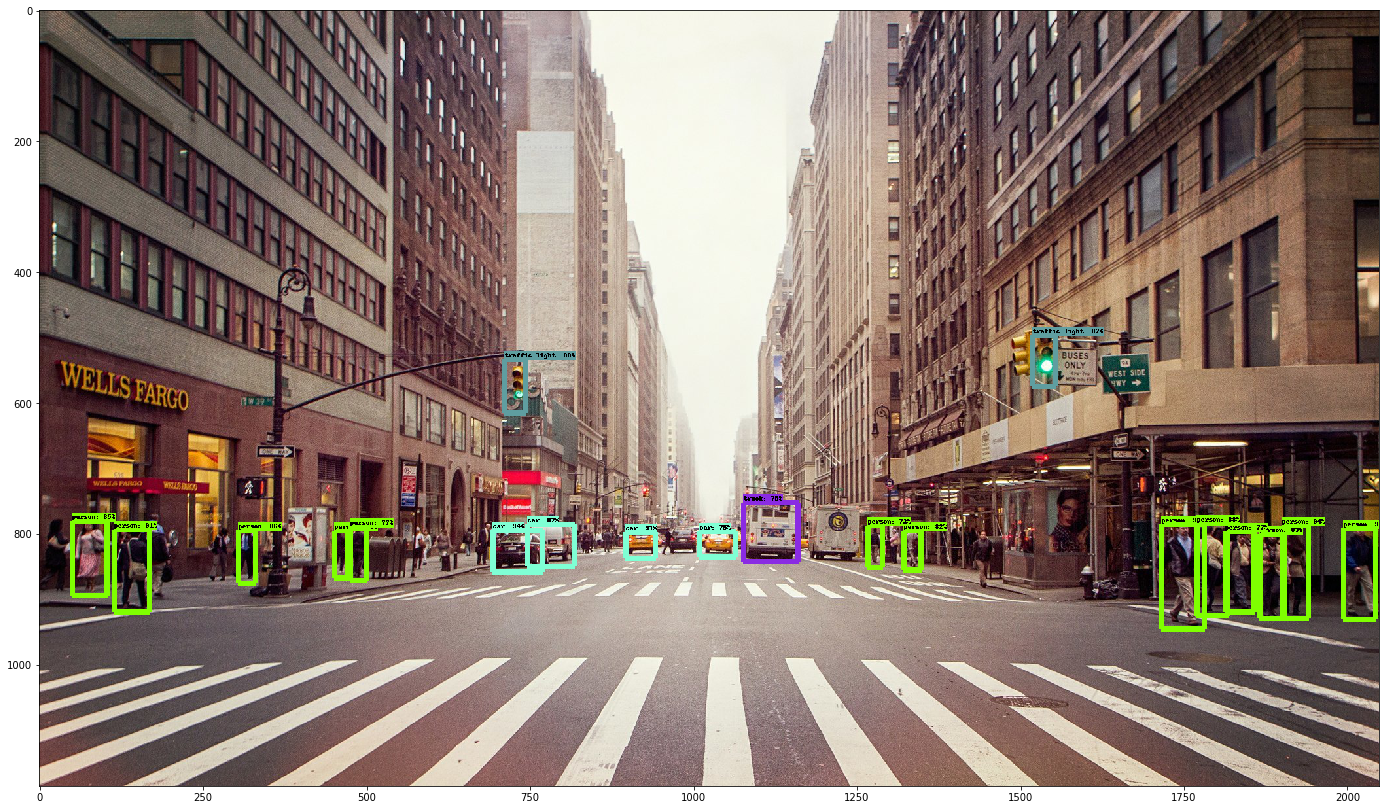

In [25]:
vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
plt.figure(figsize=(24, 16))
plt.imshow(image_np)